## <u>**Use the "Text" blocks to provide explanations wherever you find them necessary. Highlight your answers inside these text fields to ensure that we don't miss it while grading your HW.**</u> 

## **Setup**

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and uploading it to your drive), you can skip this section.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# First mount your drive before running these cells. 
# Create a folder for the this HW and change to that dir
%cd drive/My\ Drive/CSE519/HW3
%pwd

/content/drive/My Drive/CSE519/HW3


'/content/drive/My Drive/CSE519/HW3'

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
# Create a new API token under "Account" in the kaggle webpage and download the json file
# Upload the file by clicking on the browse 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karangada","key":"cd7aa263c4ab85a8083aad5f814084fa"}'}

In [ ]:
%mkdir /root/.kaggle
%cp kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions download -c  rossmann-store-sales

  0% 0.00/6.71M [00:00<?, ?B/s]
100% 6.71M/6.71M [00:00<00:00, 60.1MB/s]
  0% 0.00/44.0k [00:00<?, ?B/s]
100% 44.0k/44.0k [00:00<00:00, 2.89MB/s]
  0% 0.00/310k [00:00<?, ?B/s]
100% 310k/310k [00:00<00:00, 42.1MB/s]
  0% 0.00/192k [00:00<?, ?B/s]
100% 192k/192k [00:00<00:00, 12.7MB/s]


In [ ]:
%ls

cse519_hw3_KaranDipesh_Gada_113082700.ipynb  store.csv
kaggle.json                                  test.csv.zip
sample_submission.csv                        train.csv.zip


## **Section 1: Library and Data Imports (Q1)**

- Import your libraries and read the data into a dataframe. Print the head of the dataframe. 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, permutation_test_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
import sys
from xgboost import XGBRegressor

In [11]:
#fill in dtypes dict for efficient memory utilization
dtypes = {
    'Id':'Int32',
    'Store':'Int32',
    'DayOfWeek':'Int32',
    'Sales':'Float64',
    'Customers':'Int64',
    'Open':'Int32',
    'StateHoliday':'category',
    'SchoolHoliday':'Int32',
    'StoreType':'category',
    'Assortment':'category',
    'CompetitionDistance':'Float64',
    'CompetitionOpenSinceMonth':'object',
    'CompetitionOpenSinceYear':'object',
    'Promo':'Int32',
    'Promo2':'Int32',
    'Promo2SinceWeek':'object',
    'Promo2SinceYear':'object',
    'PromoInterval':'object',

}

parse_date = ['Date']

In [12]:
trainData = pd.read_csv('train.csv.zip', dtype=dtypes, parse_dates=parse_date)
trainData.sort_values('Date', inplace=True)

In [13]:
storeData = pd.read_csv('store.csv',dtype=dtypes)

In [14]:
mergedData = trainData.merge(storeData, how='left', on='Store')

In [8]:
mergedData.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0.0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22,2012,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0.0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,378,2,2013-01-01,0.0,0,0,0,a,1,a,c,2140.0,8,2012,0,NaN,NaN,NaN
3,377,2,2013-01-01,0.0,0,0,0,a,1,a,c,100.0,6,2010,1,18,2010,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0.0,0,0,0,a,1,a,a,160.0,8,2012,0,NaN,NaN,NaN


## **Section 2: Effect of Holidays (Q2)**

<font color='cyan'> As seen below only 20 of the total Stores are Open during Christmas; only 32 of the total Stores are Open during Easter and only 156 of the total Stores are Open during other state holidays.
</font>

In [9]:
print('Stores that Open during StateHolidays are %d out of Total Stores %d' 
      % (trainData.loc[(trainData['StateHoliday']=='c') & (trainData['Open'] == 1)]['Store'].unique().shape[0], trainData['Store'].unique().shape[0]))

Stores that Open during StateHolidays are 20 out of Total Stores 1115


In [10]:
print('Stores that Open during StateHolidays are %d out of Total Stores %d' 
      % (trainData.loc[(trainData['StateHoliday']=='b') & (trainData['Open'] == 1)]['Store'].unique().shape[0], trainData['Store'].unique().shape[0]))

Stores that Open during StateHolidays are 32 out of Total Stores 1115


In [11]:
print('Stores that Open during StateHolidays are %d out of Total Stores %d' 
      % (trainData.loc[(trainData['StateHoliday']=='a') & (trainData['Open'] == 1)]['Store'].unique().shape[0], trainData['Store'].unique().shape[0]))

Stores that Open during StateHolidays are 156 out of Total Stores 1115


<font color='cyan'>Since the nature of `StateHoliday=a` is not known, its not possible to understand will it effect the Sales. So, I consider only `b` and `c` StateHoliday i.e. Christmas and Easter. To consider the impact on Sales here, I consider the Stores that are Open during either of the StateHoliday (Christmas or Easter).
I have plotted the Average Sales per Week over time and made vertical lines to indicate the StateHoliday.<br>
It is observed that for Easter the Sales are higher during the Holiday rather than before Holiday.<br>
For Christmas the peak before the Christmas indicator suggests that people shop more before the Christmas than during Christmas hoiliday.
</font>

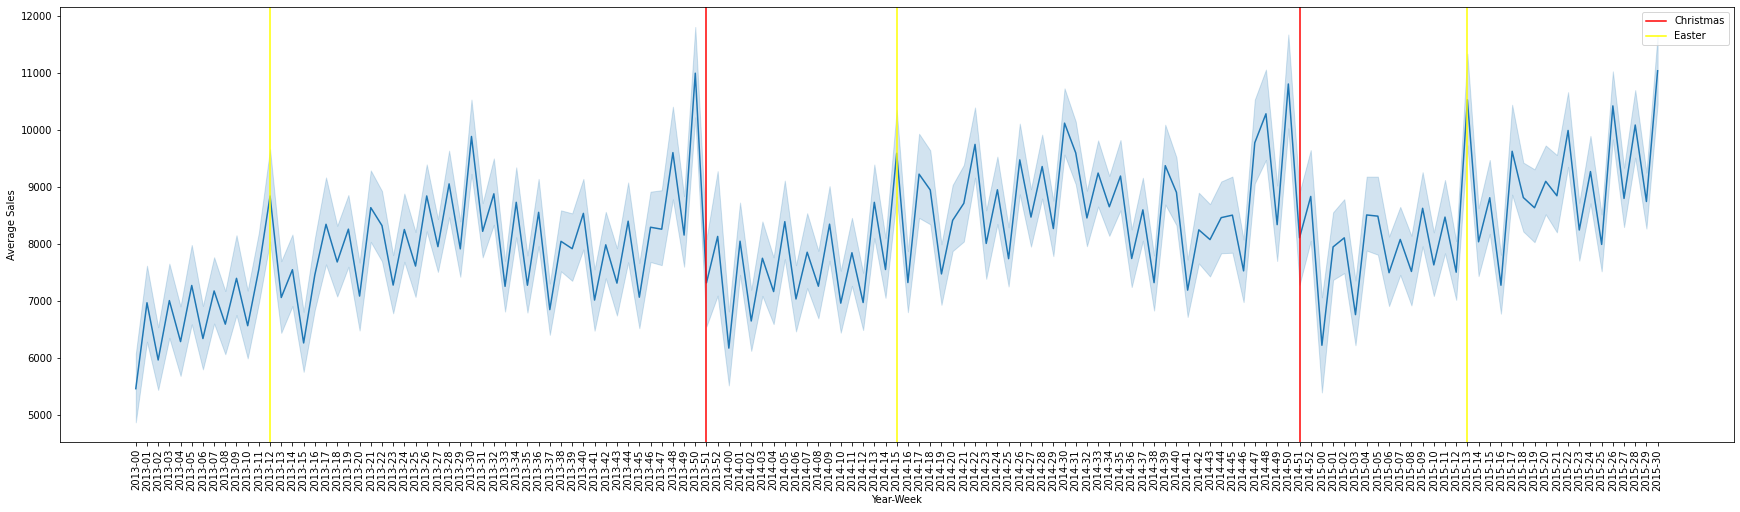

In [12]:
q2Stores = trainData.loc[((trainData['StateHoliday']=='c') | (trainData['StateHoliday']=='b')) & (trainData['Open'] == 1)]['Store'].unique()
q2Data = trainData[trainData['Store'].isin(q2Stores)].copy()
q2Data['Year-Week'] = q2Data['Date'].dt.strftime('%Y-%W')
plt.figure(figsize=(30,8))
_ = sns.lineplot(data=q2Data, x='Year-Week', y='Sales')
christmas_year = set()
easter_year = set()
for value in q2Data[q2Data['StateHoliday'] == 'c']['Year-Week'].unique():
  if not value.split('-')[0] in christmas_year:
    christmas_year.add(value.split('-')[0]) 
    l1 = plt.axvline(value, color='red', label='Christmas')
for value in q2Data[q2Data['StateHoliday'] == 'b']['Year-Week'].unique():
  if not value.split('-')[0] in easter_year:
    easter_year.add(value.split('-')[0])
    l2 = plt.axvline(value, color='yellow', label='Easter')
_, _ = plt.xticks(rotation='vertical')
_ = plt.ylabel('Average Sales')
_ = plt.legend((l1,l2), ('Christmas', 'Easter'))

## **Section 3: Most and Least selling stores (Q3a & Q3b)**

###<font color='cyan'> List For Highest and Lowest Cumulative Sales
The following code finds stores with atleast 6 months of data and finds the stores with 5 highest and 5 lowest total sales.
<br>
Highest Sales Stores (from highest to lowest) - [262, 817, 562, 1114, 251]
<br>
Lowest Sales Stores (from highest to lowest) - [263, 208, 198, 543, 307]
</font>

In [13]:
def store_sales_6monthsplus(df_):
  # df_.sort_values('Date', inplace=True)
  if (df_.iloc[-1]['Date'] - df_.iloc[0]['Date'] > pd.to_timedelta(180, unit='D')):
    return np.sum(df_['Sales'])
  else: return 

In [14]:
q3Data = trainData.groupby('Store').apply(store_sales_6monthsplus).sort_values(ascending=False)

In [15]:
highest_sales = (q3Data.index[:5].to_list())
lowest_sales = (q3Data.index[-5:].to_list())
print(highest_sales)
print(lowest_sales)

[262, 817, 562, 1114, 251]
[263, 208, 198, 543, 307]


### <font color='cyan'> Sales per Week for both Sets of Stores
Here I have taken total sales per week of highest set of stores and total sales per week of lowest set of stores over the time and plotted them on a single plot.
</font>

In [16]:
def total_sales_per_week(df_, group_store=False):
  # df_.sort_values('Date', inplace=True)
  df_['Year-Week'] = df_['Date'].dt.strftime('%Y-%W')
  group_by_ = ['Year-Week']
  if group_store: group_by_ = ['Store'] + group_by_
  return df_.groupby(group_by_)['Sales'].agg('sum')

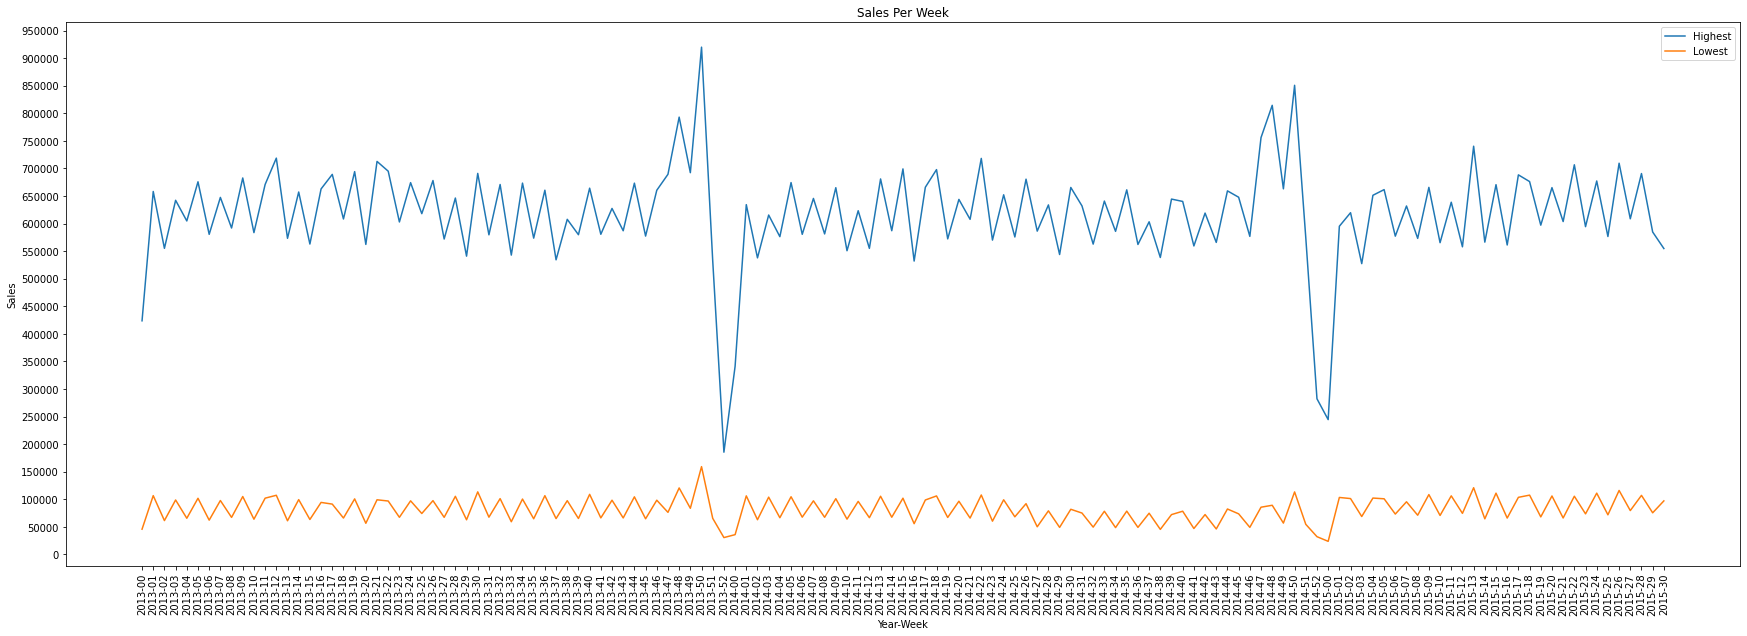

In [17]:
q3ADataHighest = total_sales_per_week(trainData.loc[trainData['Store'].isin(highest_sales)].copy())
q3ADataLowest = total_sales_per_week(trainData.loc[trainData['Store'].isin(lowest_sales)].copy())
q3AData = pd.concat([q3ADataHighest.rename('Highest'), q3ADataLowest.rename('Lowest')], axis=1)
q3AData.plot(figsize=(30,10), title='Sales Per Week', ylabel='Sales')
_,_ = plt.xticks(range(0,len(q3ADataHighest.index.to_list())),q3ADataHighest.index.to_list(), rotation='vertical')
plt.locator_params(axis="y", nbins=20)

### <font color='cyan'>Pattern of Sales among both Sets of Stores
I have plotted the sales per week for each store in both the Set of Stores.
<br>
For Highest Set, the pattern for each store are quite similar with a certain deviation for Store 262. This can be confirmed with the lower heatmap values that depicts the correlation of Sales Per Week of Store 262 against rest of the stores in the Highest Set.
<br>
For Lowest Set, the pattern for each store are quite similar aswell with a certain deviation for Store 263. This can be confirmed with the lower heatmap values that depicts the correlation of Sales Per Week of Store 263 against rest of the stores in the Lowest Set.
</font>

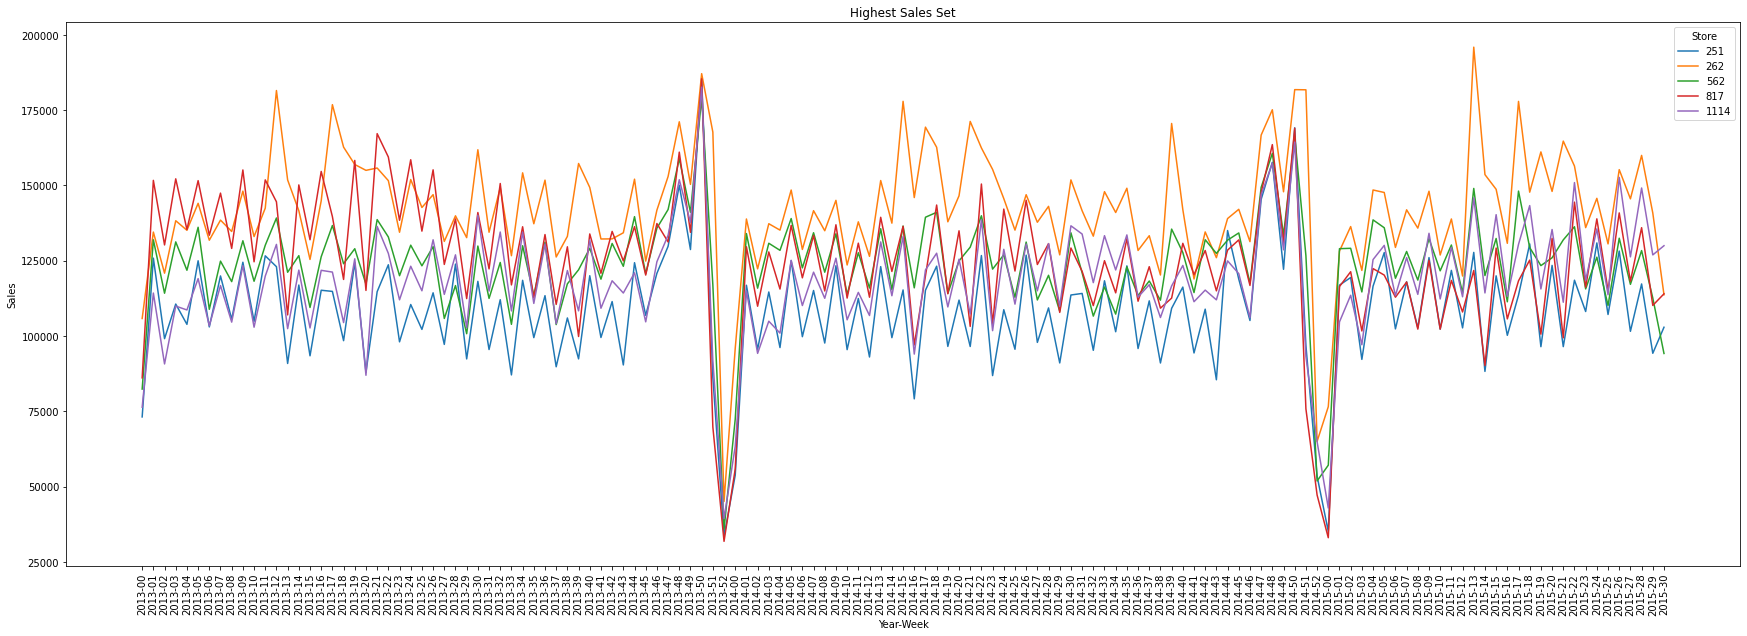

In [18]:
q3BDataHighest = total_sales_per_week(trainData.loc[trainData['Store'].isin(highest_sales)].copy(), True).reset_index()
q3BDataHighest = q3BDataHighest.pivot(index=['Year-Week'], columns=['Store'], values=['Sales'])
q3BDataHighest.columns = q3BDataHighest.columns.droplevel()
q3BDataHighest.plot(figsize=(30,10), title='Highest Sales Set', ylabel='Sales')
_,_ = plt.xticks(range(0,len(q3BDataHighest.index.to_list())),q3BDataHighest.index.to_list(), rotation='vertical')

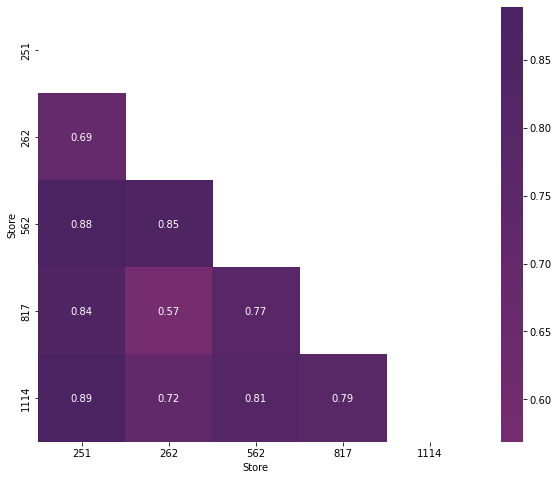

In [19]:
q3BDataHighestCorr = q3BDataHighest.corr()
mask = np.triu(np.ones_like(q3BDataHighestCorr, dtype=bool))
plt.subplots(figsize=(10,8))
_ = sns.heatmap(q3BDataHighestCorr, mask=mask, cmap='flare', center=0,
            square=True, annot=True)

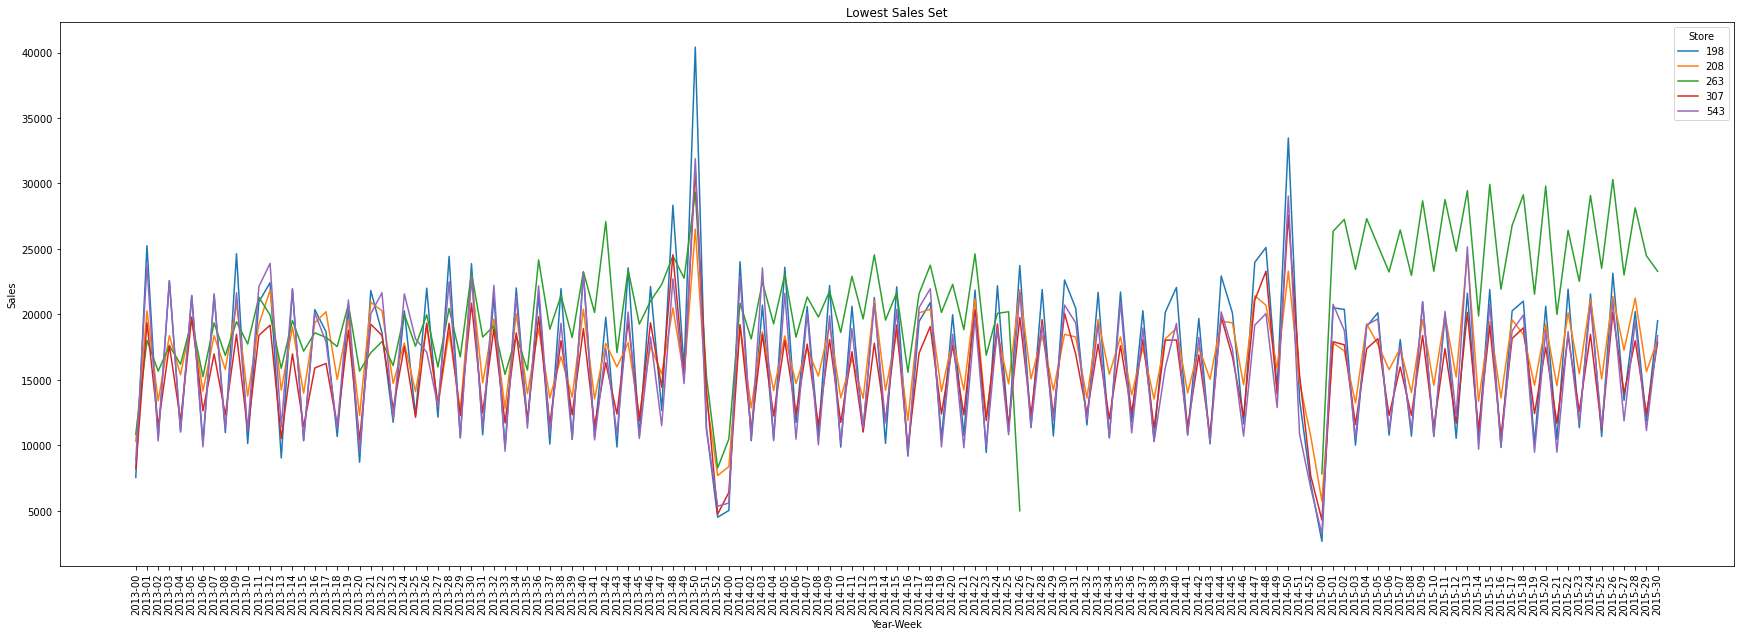

In [20]:
q3BDataLowest = total_sales_per_week(trainData.loc[trainData['Store'].isin(lowest_sales)].copy(), True).reset_index()
q3BDataLowest = q3BDataLowest.pivot(index=['Year-Week'], columns=['Store'], values=['Sales'])
q3BDataLowest.columns = q3BDataLowest.columns.droplevel()
q3BDataLowest.plot(figsize=(30,10), title='Lowest Sales Set', ylabel='Sales')
_,_ = plt.xticks(range(0,len(q3BDataLowest.index.to_list())),q3BDataLowest.index.to_list(), rotation='vertical')

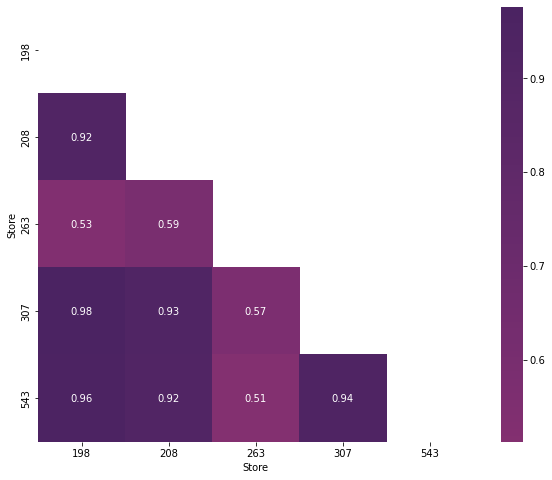

In [21]:
q3BDataLowestCorr = q3BDataLowest.corr()
mask = np.triu(np.ones_like(q3BDataLowestCorr, dtype=bool))
plt.subplots(figsize=(10,8))
_ = sns.heatmap(q3BDataLowestCorr, mask=mask, cmap='flare', center=0,
            square=True, annot=True)

## **Section 4: Closest Competitor: Distance and Age (Q4a & Q4b)**

### <font color='cyan'> Sales per Week VS Competitor
There were 3 stores that didn't have competitor distance and hence were removed from the data in cleaning stage as it's very difficult to predict if they didn't have competition or was the data missing.
<br>
I have plotted Average `Sales per Week` for every store vs the `Distance` of it from its Competitor. As the plot suggests the Distribution is quite scattered.
<br>
One would expect the `Sales` should increase as the `Distance` decrease. However, this is not the case. This can be confirmed with the correlation of `Sales`vs `CompetitorDistance` which turns out to be very insignificant.
</font>

In [22]:
q4Data = pd.DataFrame(total_sales_per_week(trainData, True).groupby('Store').agg('mean'))
q4Data = storeData.join(q4Data, on='Store', how='inner')
q4Data.set_index('Store', inplace=True)

In [23]:
q4AData = q4Data[['CompetitionDistance', 'Sales']].dropna(how='any', axis=0)

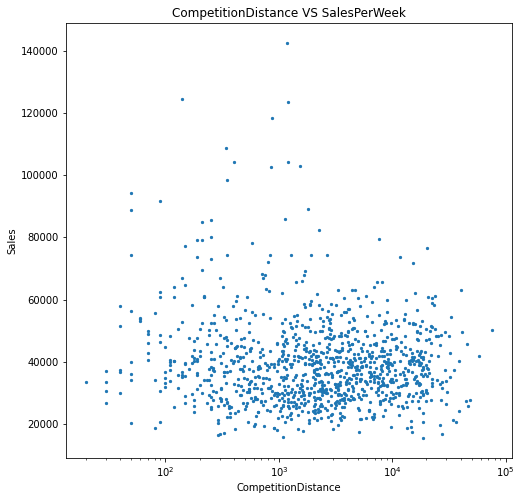

In [24]:
_ = q4AData.sort_values('CompetitionDistance').plot.scatter('CompetitionDistance', 'Sales', figsize=(8,8), ylabel='SalesPerWeek', title='CompetitionDistance VS SalesPerWeek', logx=True, s=5)

In [25]:
q4AData.corr()

,CompetitionDistance,Sales
CompetitionDistance,1.000000,-0.033615
Sales,-0.033615,1.000000


## **Section 5: Pearson Correlation of Features (Q5)**

###<font color='cyan'> Pearson's Correlation
List of 5 interesting features - `'DayOfWeek', 'Customers', 'Open', 'Promo', 'Sales'`
<br>
Customer-Sales have the best positive correlation.
</font>
###<font color='cyan'>Spearman's Correlation
The heatmap and the correlation within the features don't change significantly with Spearman's correlation.
</font>

In [26]:
correlation_features = ['DayOfWeek', 'Customers', 'Open', 'Promo', 'Sales']

In [27]:
q5Data = mergedData[correlation_features]

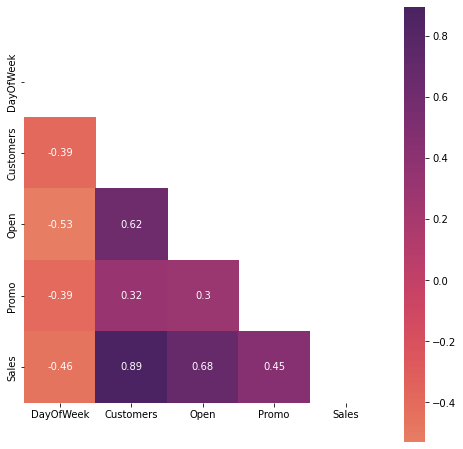

In [28]:
q5Pearson = q5Data.corr()
mask = np.triu(np.ones_like(q5Pearson, dtype=bool))
cmap = sns.color_palette('flare', as_cmap=True)
plt.subplots(figsize=(8,8))
_ = sns.heatmap(q5Pearson, mask=mask, cmap=cmap, center=0, square=True, annot=True)

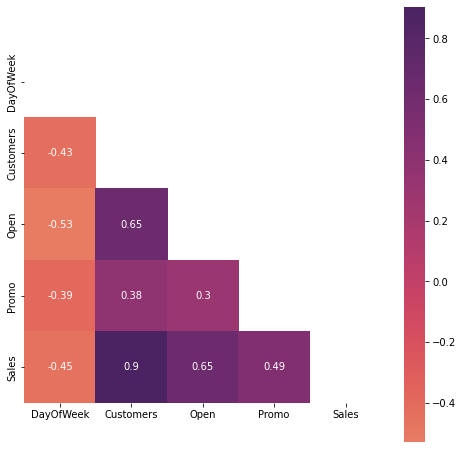

In [29]:
q5Pearson = q5Data.corr('spearman')
mask = np.triu(np.ones_like(q5Pearson, dtype=bool))
cmap = sns.color_palette('flare', as_cmap=True)
plt.subplots(figsize=(8,8))
_ = sns.heatmap(q5Pearson, mask=mask, cmap=cmap, center=0, square=True, annot=True)

## **Section 6: Permutation Testing (Q6)**

<font color='cyan'>Good Variable - `Customers`<br>
Meaningless - `CompetitionDistance`<br>
Random - `DayOfWeek`<br>
The pvalue suggests -<br>
1. Prediction using `Customers` are better than chance with probability of `0.99`
1. Prediction using `CompetitionDistance` are better than chance with probability of `0`
1. Prediction using `DayOfWeek` are better than chance with probability of `0.99`
</font>

In [30]:
q6X = mergedData[['CompetitionDistance']].fillna(0)
q6Y = mergedData['Sales']
true_rmsle, shuffle_rmsle_list, pvalue = permutation_test_score(LinearRegression(), q6X, q6Y, scoring='neg_mean_squared_log_error', n_permutations=100)
print('The p-value which approximates the probability that the score would be obtained by chance %.5f' % pvalue)

The p-value which approximates the probability that the score would be obtained by chance 1.00000


In [31]:
q6X = mergedData[['Customers']]
q6Y = mergedData['Sales']
true_rmsle, shuffle_rmsle_list, pvalue = permutation_test_score(LinearRegression(), q6X, q6Y, scoring='neg_mean_squared_log_error', n_permutations=100)
print('The p-value which approximates the probability that the score would be obtained by chance %.5f' % pvalue)

The p-value which approximates the probability that the score would be obtained by chance 0.00990


In [32]:
q6X = mergedData[['DayOfWeek']]
q6Y = mergedData['Sales']
true_rmsle, shuffle_rmsle_list, pvalue = permutation_test_score(LinearRegression(), q6X, q6Y, scoring='neg_mean_squared_log_error', n_permutations=100)
print('The p-value which approximates the probability that the score would be obtained by chance %.5f' % pvalue)

The p-value which approximates the probability that the score would be obtained by chance 0.00990


## **Section 7: Interesting findings (Q7)**

###<font color='cyan'> Plot 1
This is a bar chart for count of Stores for different `Assortment`. We realize very less Stores follow `type b` Assortment. It arouses curiosity why are the Stores not adopting `type b` Assortment?
</font>

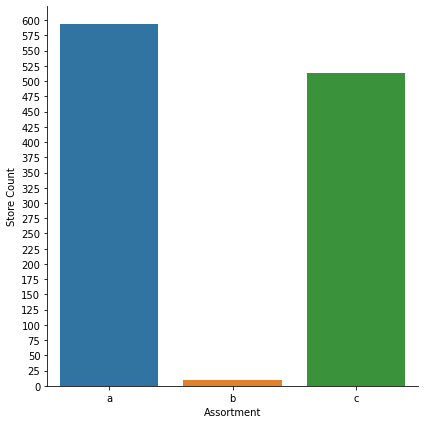

In [33]:
_ = sns.catplot(data=storeData, x='Assortment', kind='count', height=6, aspect=1)
_ = plt.ylabel('Store Count')
_ = plt.locator_params(axis='y', nbins=30)

###<font color='cyan'> Plot 2
To answer the question arisen by Plot 1, I plotted Scatter Plot for `Customers` vs `Sales` for all types of Assortment (differentiated by hue/color). Its observed that for `type b` Assortment Stores the Sales-to-Customers ratio is significantly lower than for `type a` and `type c`. This explain why most of the Stores avoid adopting `type b` Assortment.
</font>

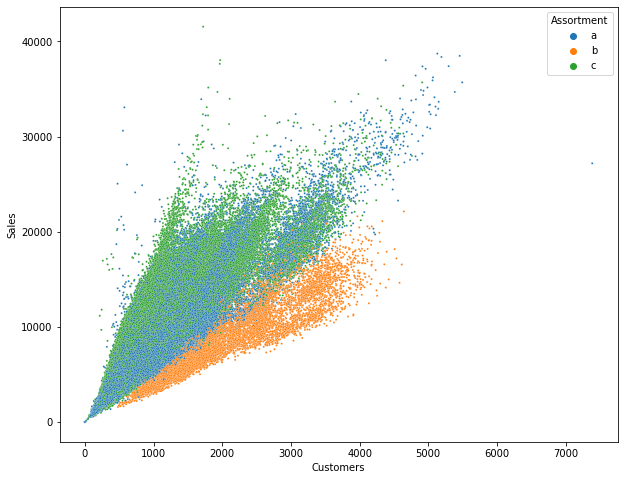

In [34]:
plt.figure(figsize=(10,8))
_ = sns.scatterplot(data=mergedData, x='Customers', y='Sales', s=4, hue='Assortment')

###<font color='cyan'> Plot 3
I plotted a Lineplot to understand the Average Sales per month over time of the Stores with different `StoreType`. The plot reveals that `type b` has a humongous Average Sales per month over time in comparison to other `StoreType`. So, it must be good to have a `StoreType` as `type b`. So how many of the Stores follow `type b` StoreType?
</font>

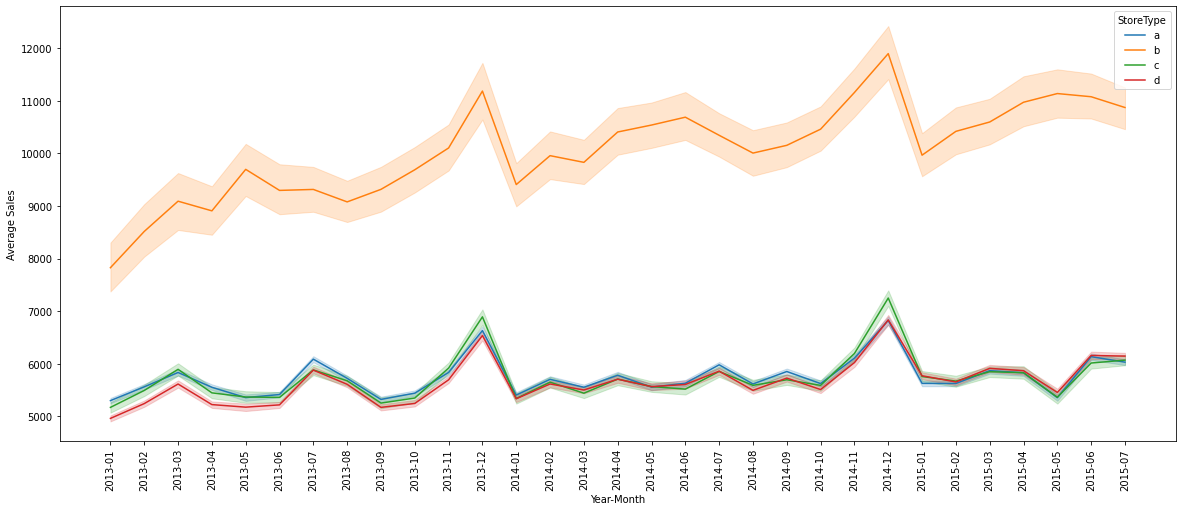

In [35]:
q7E = mergedData.copy()
q7E['Year-Month'] = q7E['Date'].dt.strftime('%Y-%m')
plt.figure(figsize=(20,8))
_ = sns.lineplot(data=q7E, x='Year-Month', y='Sales', hue='StoreType')
_, _ = plt.xticks(rotation='vertical')
_ = plt.ylabel('Average Sales')

###<font color='cyan'> Plot 4
As seen in below Barplot, only a handful of the Stores actually have `type b` as the `StoreType`. Why is that even with good Average Sales per month, very few Stores follow `type b` StoreType? Is the above Lineplot skewed because of less data point (just lucky) or are there more reasons?
</font>

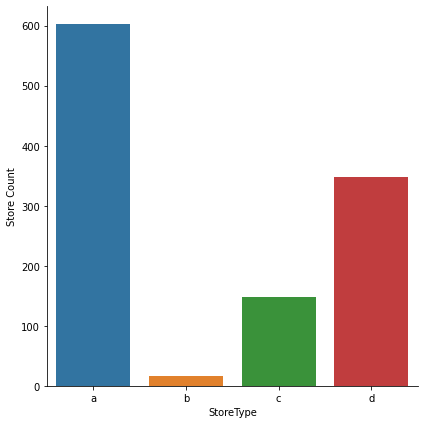

In [36]:
_ = sns.catplot(data=storeData, x='StoreType', kind='count', height=6, aspect=1)
_ = plt.ylabel('Store Count')

###<font color='cyan'> Plot 5
The below ScatterPlot for `Customers` vs `Sales` reveals that although the Sales are high for `type b` StoreType the Sales-to-Customers ratio is less than `type a`, `type b` and `type c` StoreType. This would make stakeholders inclined towards type `a`, `b`, `c` StoreType. 
</font> 

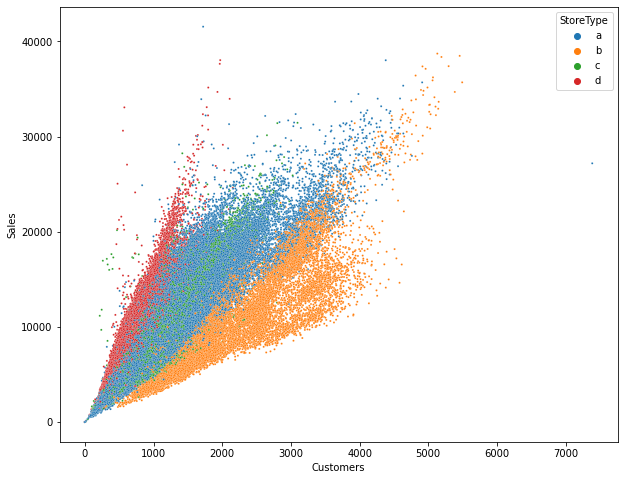

In [37]:
plt.figure(figsize=(10,8))
_ = sns.scatterplot(data=mergedData, x='Customers', y='Sales', s=4, hue='StoreType')

###<font color='cyan'> Plot 6
Additionally the below Barplot also reveals that `type b` StoreType is most probable to stay Open throughout the `StateHolidays` making it very unlikely to open up more stores with this StoreType. This can be due to logistical constraints.
</font>

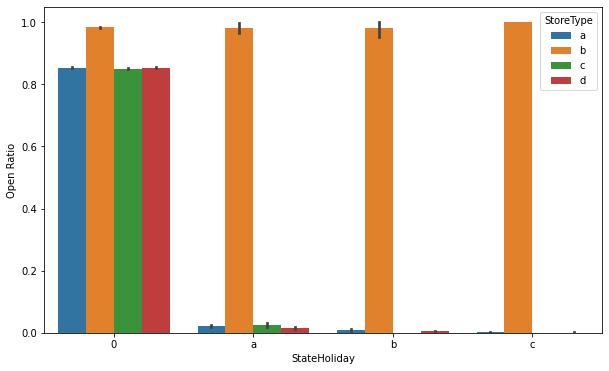

In [38]:
plt.figure(figsize=(10,6))
_ = sns.barplot(data=mergedData, x='StateHoliday', y='Open', hue='StoreType')
_ = plt.ylabel('Open Ratio')

## **Section 8: Train Test Split and Modelling (Q8)**

###<font color='cyan'>Model 1 - Decision Tree
`splitter` is the strategy used to split at each node. I have used `best` and `random` as values in different models.<br>
`criterion` is the measure of the quality of a split. I have used `mse` which is mean squred error.<br>
`max_depth` is the maximum level (depth) of the DecisionTree. If unspecified it expands till all leaves are pure. If a value is provided it expands tree only till the given depth.
1. HyperParameter 1 - `splitter=random`, `criterion=mse`
2. HyperParameter 2 - `splitter=random`, `criterion=mse`, `max_depth=25`
3. HyperParameter 3 - `splitter=best`, `criterion=mse`, `max_depth=100`
</font>

###<font color='cyan'> Model 2 - RandomForest
RandomForest is an ensemble models that predicts using the prediction of many weak models (DecisionTree).<br>
`n_estimators` specifies the number of weak models to use. I have used `5`, `10`, `200` as the estimators.<br>
`bootstrap` is the parameter to specify bootstrapping in ensemble. In bootstrapping, samples are drawn with replacement to train each estimator, at times same samples are used multiple times for the same estimator. In this way although each estimator might have high variance wrt particular set of training data byt predictions are made by averaging the predictions of all estimators called as Bagging. If False, all train data is used for each estimator.
1. HyperParameter 1 - `n_estimators=5`, `bootstrap=False`
2. HyperParameter 2 - `n_estimators=10`, `bootstrap=False`
3. HyperParameter 3 - `n_estimators=200`, `bootstrap=True`
</font> 
 

In [15]:
q7X = mergedData.copy()
q7X['Month'] = q7X['Date'].dt.month

In [16]:
def RMSPE(YTrue, YPred):
  return np.sqrt(np.mean(np.square((YTrue[~(YTrue==0)] - YPred[~(YTrue==0)])/(YTrue[~(YTrue==0)]))))

In [17]:
ordinal_feat = ['DayOfWeek', 'Assortment', 'Month']
nominal_feat = ['StateHoliday', 'StoreType']
passthrough_feat = ['Store', 'Open', 'Promo', 'SchoolHoliday']
target = 'Sales'

In [18]:
q7X = q7X[['Date'] + ordinal_feat + nominal_feat + passthrough_feat + [target]]

In [19]:
split_sdate = pd.to_datetime('2015-05-01', format='%Y-%m-%d')
split_edate = pd.to_datetime('2015-07-31', format='%Y-%m-%d')
q7XTrain, q7XTest = q7X[(q7X['Date']<split_sdate) | (q7X['Date']>split_edate)], q7X[(q7X['Date']>=split_sdate) & (q7X['Date']<=split_edate)]
q7YTrain = q7XTrain.pop('Sales')
q7YTest = q7XTest.pop('Sales')

In [20]:
column_transformer = ColumnTransformer(transformers=[
                                                     ('ordinal_data', OrdinalEncoder(), ordinal_feat),
                                                     ('nominal_data', OneHotEncoder(), nominal_feat),
                                                     ('leave_as_it_is','passthrough', passthrough_feat),
])

<font color='cyan'> The time taken for every model and the performance (RMSPE score) is printed for both models and all hyperparameterized variation below.<br>
To avoid prediction to be negative I am using `log(Sales)` as my target variable. After prediction I convert the predicted values using `np.exp` to get the actual Sales values.
</font>

In [21]:
model1_h1 = Pipeline(steps=[
                            ('column_transform', column_transformer),
                            ('regressor', DecisionTreeRegressor(splitter='random',criterion='mse')),
], verbose=True)

model1_h1.fit(q7XTrain, np.log(1+q7YTrain))
model1_h1_YPred = np.exp(model1_h1.predict(q7XTest))
print(RMSPE(q7YTest, model1_h1_YPred))

[Pipeline] .. (step 1 of 2) Processing column_transform, total=   1.6s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s
0.15789730593147508


In [22]:
model1_h2 = Pipeline(steps=[
                            ('column_transform', column_transformer),
                            ('regressor', DecisionTreeRegressor(splitter='random',criterion='mse', max_depth=25)),
], verbose=True)

model1_h2.fit(q7XTrain, np.log(1+q7YTrain))
model1_h2_YPred = np.exp(model1_h2.predict(q7XTest))
print(RMSPE(q7YTest, model1_h2_YPred))

[Pipeline] .. (step 1 of 2) Processing column_transform, total=   1.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.0s
0.20924852955314885


In [23]:
model1_h3 = Pipeline(steps=[
                            ('column_transform', column_transformer),
                            ('regressor', DecisionTreeRegressor(splitter='best',criterion='mse', max_depth=100)),
], verbose=True)

model1_h3.fit(q7XTrain, np.log(1+q7YTrain))
model1_h3_YPred = np.exp(model1_h3.predict(q7XTest))
print(RMSPE(q7YTest, model1_h3_YPred))

[Pipeline] .. (step 1 of 2) Processing column_transform, total=   1.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   4.0s
0.15437086352497184


In [24]:
model2_h1 = Pipeline(steps=[
                            ('column_transform', column_transformer),
                            ('regressor', RandomForestRegressor(n_estimators=5, bootstrap=False))
], verbose=True)
model2_h1.fit(q7XTrain, np.log(1+q7YTrain))
model2_h1_YPred = np.exp(model2_h1.predict(q7XTest))
print(RMSPE(q7YTest, model2_h1_YPred))

[Pipeline] .. (step 1 of 2) Processing column_transform, total=   1.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  19.4s
0.1543699479352234


In [25]:
model2_h2 = Pipeline(steps=[
                            ('column_transform', column_transformer),
                            ('regressor', RandomForestRegressor(n_estimators=10, bootstrap=False))
], verbose=True)
model2_h2.fit(q7XTrain, np.log(1+q7YTrain))
model2_h2_YPred = np.exp(model2_h2.predict(q7XTest))
print(RMSPE(q7YTest, model2_h2_YPred))

[Pipeline] .. (step 1 of 2) Processing column_transform, total=   1.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  38.8s
0.15437115016609812


In [26]:
model2_h3 = Pipeline(steps=[
                            ('column_transform', column_transformer),
                            ('regressor', RandomForestRegressor(n_estimators=200, bootstrap=True))
], verbose=True)
model2_h3.fit(q7XTrain, np.log(1+q7YTrain))
model2_h3_YPred = np.exp(model2_h3.predict(q7XTest))
print(RMSPE(q7YTest, model2_h3_YPred))

[Pipeline] .. (step 1 of 2) Processing column_transform, total=   1.7s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 8.5min
0.15137566728893614


## **Section 9: t-test (Q9)**

<font color='cyan'> I have taken the predictions from Model 1:HyperParameter 1 and Model 2:HyperParameter 3 to perform T-test.<br>
The T-statistic `-0.164`<br>
The p-value `0.86` suggests that the Null Hypothesis that both the predictions are samples of same distribution cannot be rejected.
Hence the predictions are not different significantly.

In [53]:
ttest_ind(model1_h1_YPred, model2_h3_YPred)

Ttest_indResult(statistic=-0.1641275840481657, pvalue=0.8696308690108223)

## **Section 10: Screenshots (Q10)** 

In [28]:
testData = pd.read_csv('test.csv.zip', dtype=dtypes, parse_dates=['Date'])
testData[testData['Open'].isnull()]

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
479,480,622,4,2015-09-17,<NA>,1,0,0
1335,1336,622,3,2015-09-16,<NA>,1,0,0
2191,2192,622,2,2015-09-15,<NA>,1,0,0
3047,3048,622,1,2015-09-14,<NA>,1,0,0
4759,4760,622,6,2015-09-12,<NA>,0,0,0
5615,5616,622,5,2015-09-11,<NA>,0,0,0
6471,6472,622,4,2015-09-10,<NA>,0,0,0
7327,7328,622,3,2015-09-09,<NA>,0,0,0
8183,8184,622,2,2015-09-08,<NA>,0,0,0
9039,9040,622,1,2015-09-07,<NA>,0,0,0


In [29]:
testData.loc[testData['Open'].isnull(), 'Open'] = 1

In [30]:
testData = testData.merge(storeData, how='left', on='Store')
testData['Month'] = testData['Date'].dt.month
testData.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Month
0,1,1,4,2015-09-17,1,1,0,0,c,a,1270.0,9,2008,0,NaN,NaN,NaN,9
1,2,3,4,2015-09-17,1,1,0,0,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",9
2,3,7,4,2015-09-17,1,1,0,0,a,c,24000.0,4,2013,0,NaN,NaN,NaN,9
3,4,8,4,2015-09-17,1,1,0,0,a,a,7520.0,10,2014,0,NaN,NaN,NaN,9
4,5,9,4,2015-09-17,1,1,0,0,a,c,2030.0,8,2000,0,NaN,NaN,NaN,9


In [31]:
testData_transformed = testData[['Date'] + ordinal_feat + nominal_feat + passthrough_feat]

<font color='cyan'> With Model 2:Hyperparameter 3 </font>

In [43]:
test_YPred = np.exp(model2_h3.predict(testData_transformed))

In [44]:
test_YPred = pd.Series(test_YPred, index=testData['Id'], name='Sales').reset_index()
test_YPred.head()

,Id,Sales
0,1,4426.849557
1,2,7748.966359
2,3,8926.443493
3,4,6575.015780
4,5,5923.583692


In [45]:
test_YPred.to_csv('model2_hyperparam3.csv', index=False)

<font color='cyan'> With Model 1:Hyperparameter 3 </font>

In [32]:
test_YPred = np.exp(model1_h3.predict(testData_transformed))

In [33]:
test_YPred = pd.Series(test_YPred, index=testData['Id'], name='Sales').reset_index()
test_YPred.head()

,Id,Sales
0,1,4399.882624
1,2,7724.909284
2,3,8964.494214
3,4,6583.028626
4,5,5879.805506


In [34]:
test_YPred.to_csv('model1_hyperparam3.csv', index=False)

Public Score & Highest Rank: 0.15342

Private Score & Highest Rank: 0.15616

Kaggle profile link: https://www.kaggle.com/karangada

Screenshot(s): 